# Classification

In [18]:
#Common Imports
import numpy as np

sklearn has datasets and they all follow a similar dictionary structure as follows

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Data consists of 70k, 28x28 images, with intensity ranging from 0 (white) to 255 (black)

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

To generate an image from an instance, use Matplotlib's `imshow()`

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

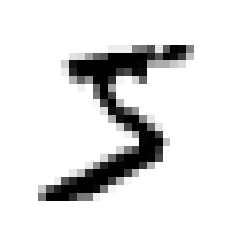

In [15]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

Check label

In [16]:
y[0]

'5'

Useful to cast string label into an integer (unsigned, 8 bit [0,255])

In [19]:
y = y.astype(np.uint8)

Should always create a test set (and set it aside) before inspecting the data as a whole (to avoid brain's *snooping bias*). In this case, train/test has already been shuffled and split into the first 60k from sklearn. Recall considerations like stratified sampling, and in this case, similar examples in mass back to back

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

First lets simplify it and classify based on two classes, 5's of not 5's.

In [22]:
y_train_5 = (y_train == 5) # True for all 5's, false otherwise
y_test_5 = (y_test == 5)

Elect to use a stochastic gradient descent classifier. Recall SGD is a sequential update method for the model params $(\mathbf w^{(\tau+1)} = \mathbf w^{(\tau)} - \eta \nabla E_n)$

In [23]:
from sklearn.linear_model import SGDClassifier

# epochs = 1000, loss stop = tol
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [26]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

Many performance measures in classification as compared to regression

### Measuring Accuracy Using Cross-Validation

Nice implementation of cross-validation from scratch that achieves the same result as built-in sklearn `cross_val_scrore`; useful if one needs to fine tune K-fold cross val. (pg 89)

In [27]:
from sklearn.model_selection import cross_val_score
# returns ratio of correct predictions
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Caution to interpret as good classifier, since 5's only constitute a small portion of overall dataset. Let's compare to one that classifies everything as a non-5. 

In [29]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [30]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Demonstrates issue using accuracy in *skewed* dataset (in conjunction with binary classification)

### Confusion Matrix

Better to evaluate classifier performance using *confusion matrix*, which counts the number of times instances of a class *A* are classfied as class *B*

Remember not to touch test set yet. First generate predictions, then generate confusion matrix via:

In [39]:
from sklearn.model_selection import cross_val_predict
# can also perform cross validation
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Rows represent actual classes (must have a basis of comparison), columns represent predicted class

[ true negative, false positive], [false negative, true positive]

In [37]:
y_train_perfect_pred = y_train_5 #pretend perfection
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

More concise to work with *precision* and *recall*, which look at relative accuracies from confusion matrix
$$ precision = \frac{TP}{TP + FP}$$
Precision can be trivially achieved by predicting a single TP result, and classifier rest as negative. Thus we should also include *recall* (aka *sensitivity*, *true positive rate (TPR)*)
$$ recall = \frac{TP}{TP + FN}$$

In [42]:
from sklearn.metrics import precision_score, recall_score

# When it claims an image is a 5, only predicts correctly 83% of the time
# (Given a prediction of 5, only 83% accurate)
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [44]:
# Only detects 65% of the 5's
# (Given the image is a 5, 65% prediction accuracy)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Conveinent to assign single score using precision and recall, called *F_1 score*. It is the harmonic mean of precision and recall, giving larger weight to lower score. Harmonic mean is the reciprocal of the arithmetic mean of the reciprocals of a given set of observations. Useful for calculating averages of rates and ratios (e.g. scenario of traveling a distance *d* at speed *x* outboud and traveling same distance *d* at speed *y* inbound. Different speeds imply different trip times, so what is really the average speed? It is not the arithmetic mean, but rather $\frac{total\_distance\_traveled}{total\_time} = \frac{2d}{d/x + d/y} = \frac{2}{1/x + 1/y}$)

$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$$

In [46]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F_1 classifier favors similar precision and recall. Not always ideal, depends hevaily upon design goals given data, factoring in weightings for false positives and so forth.  

### Precision/Recall Trade-Off

Increasing precision decreases recall, vice versa. 